In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
#Reading the csv files into dataframes and checking their shapes
train = pd.read_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/input/train.csv')
test = pd.read_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/input/test.csv')
store = pd.read_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/input/store.csv')
print(train.shape)
print(test.shape)
print(store.shape)

(1017209, 9)
(41088, 8)
(1115, 10)


In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [7]:
train.describe(include='object').T

,count,unique,top,freq
Date,1017209,942,2015-04-23,1115
StateHoliday,1017209,5,0,855087


In [8]:
train.describe()[['Sales', 'Customers']].loc['max']

Sales        41551.0
Customers     7388.0
Name: max, dtype: float64

In [9]:
train.Store.nunique()

1115

In [10]:
train.DayOfWeek.value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [11]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

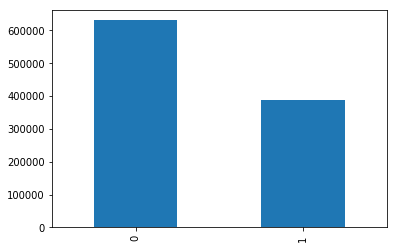

In [12]:
# Checking how many stores have done the promotion 
train.Promo.value_counts().plot(kind='bar')

In [13]:
#Converting the Date into datetime and in Y-m-d format
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')

In [14]:
store_id = train.Store.unique()[0]

In [15]:
#Getting the stores with unique store-id
store_rows = train[train['Store']== train.Store.unique()[0]]
store_rows.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


In [16]:
#Getting the stores with zero sales , effectively it might be holiday
store_rows[store_rows['Sales']==0].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
5575,1,7,2015-07-26,0,0,0,0,0,0
13380,1,7,2015-07-19,0,0,0,0,0,0
21185,1,7,2015-07-12,0,0,0,0,0,0
28990,1,7,2015-07-05,0,0,0,0,0,0
36795,1,7,2015-06-28,0,0,0,0,0,0


In [17]:
#Converting the Date in datetime format
test['Date'] = pd.to_datetime(test['Date'], format='%Y-%m-%d')

In [18]:
store_test_rows = test[test['Store'] == train.Store.unique()[0]]

In [19]:
store_test_rows.Date.min()

Timestamp('2015-08-01 00:00:00')

In [20]:
store_test_rows.Date.max()

Timestamp('2015-09-17 00:00:00')

In [21]:
store_test_rows.Open.value_counts()

1.0    41
0.0     7
Name: Open, dtype: int64

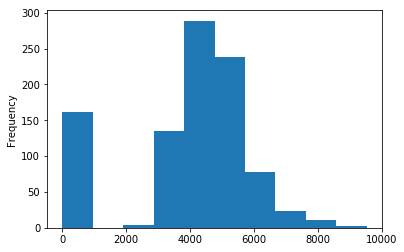

In [22]:
#Plotting the Sales histogram and its not normal. One of reason being there are stores with zero sales as well 
#due to holidays
store_rows.Sales.plot.hist()

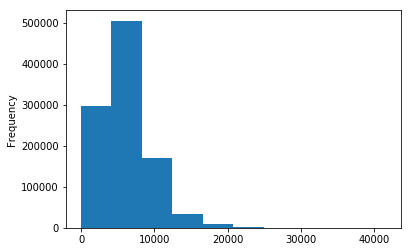

In [23]:
#Ploting the Sales historgram of train data. Again it is not normal
train.Sales.plot.hist()

In [24]:
store.head()
store[store['Store']==store_id].T

test.head()
test[test['Store']==store_id].T

,0,856,1712,2568,3424,4280,5136,5992,6848,7704,...,32528,33384,34240,35096,35952,36808,37664,38520,39376,40232
Id,1,857,1713,2569,3425,4281,5137,5993,6849,7705,...,32529,33385,34241,35097,35953,36809,37665,38521,39377,40233
Store,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DayOfWeek,4,3,2,1,7,6,5,4,3,2,...,1,7,6,5,4,3,2,1,7,6
Date,2015-09-17 00:00:00,2015-09-16 00:00:00,2015-09-15 00:00:00,2015-09-14 00:00:00,2015-09-13 00:00:00,2015-09-12 00:00:00,2015-09-11 00:00:00,2015-09-10 00:00:00,2015-09-09 00:00:00,2015-09-08 00:00:00,...,2015-08-10 00:00:00,2015-08-09 00:00:00,2015-08-08 00:00:00,2015-08-07 00:00:00,2015-08-06 00:00:00,2015-08-05 00:00:00,2015-08-04 00:00:00,2015-08-03 00:00:00,2015-08-02 00:00:00,2015-08-01 00:00:00
Open,1,1,1,1,0,1,1,1,1,1,...,1,0,1,1,1,1,1,1,0,1
Promo,1,1,1,1,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0
StateHoliday,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SchoolHoliday,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [25]:
#Finding out the null values in store and test data frame
store.isna().sum()
test.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [26]:
#Filling the NaN values for 'Open' as zero
test['Open'] = test['Open'].fillna(0)
test.isna().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [27]:
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].fillna(0)

In [28]:
store[~store['Promo2SinceYear'].isna()].iloc[0]

Store                                      2
StoreType                                  a
Assortment                                 a
CompetitionDistance                      570
CompetitionOpenSinceMonth                 11
CompetitionOpenSinceYear                2007
Promo2                                     1
Promo2SinceWeek                           13
Promo2SinceYear                         2010
PromoInterval                Jan,Apr,Jul,Oct
Name: 1, dtype: object

In [29]:
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [30]:
# Filling the NaN values appropriately
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(store['Promo2SinceYear'].mode().iloc[0])
store['PromoInterval']=store['PromoInterval'].fillna(store['PromoInterval'].mode().iloc[0])

In [31]:
# Filling the NaN values appropriately
store['CompetitionDistance']=store['CompetitionDistance'].fillna(0)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(
    store['CompetitionOpenSinceMonth'].mode().iloc[0])
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode().iloc[0])
store.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [32]:
#Merging the train dataframe with Store dataframe
train_merged=train.merge(store,on='Store',how='left')
print(train.shape)
print(train_merged.shape)

(1017209, 9)
(1017209, 18)


In [33]:
#Mergin the train dataframe with Test dataframe
test_merged=test.merge(store,on='Store',how='left')
print(test.shape)
print(test_merged.shape)

(41088, 8)
(41088, 17)


In [34]:
train_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"


In [35]:
train_merged.isna().sum().sum()
test_merged.isna().sum().sum()

0

In [36]:
#Checking datatypes of train_merged dataframe
train_merged.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

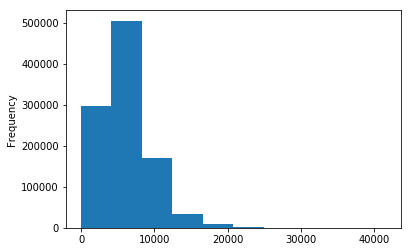

In [37]:
#Plotting the Sales histogram for train_merged data
train_merged['Sales'].plot.hist()

In [38]:
#Since some of the Sales values are zero, we are converting 'Sales' to log values
train_merged['Sales'] = np.log(train_merged['Sales']+1)

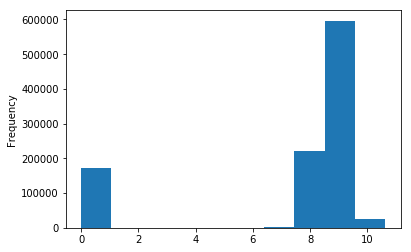

In [39]:
train_merged['Sales'].plot.hist()

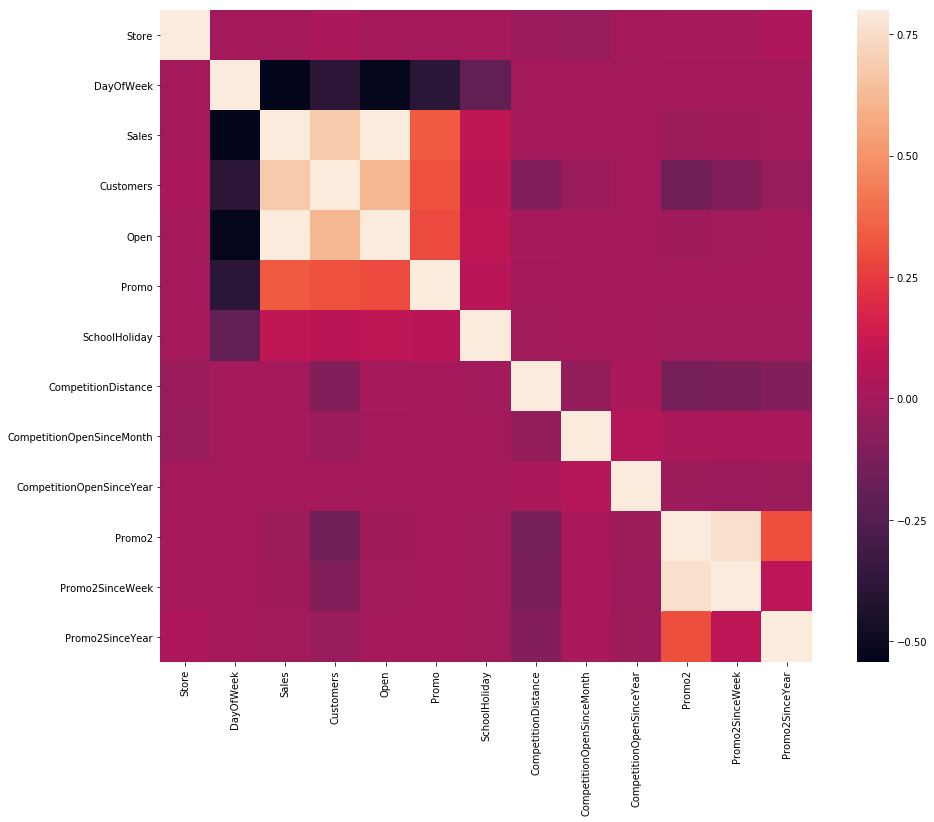

In [40]:
#correlation matrix
corrmat = train_merged.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=0.8, square=True);

In [41]:
test_merged.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct"


In [42]:
#Splitting the Date into 'Day', 'month' & 'year'
train_merged['Day']=train_merged['Date'].dt.day
train_merged['month']=train_merged['Date'].dt.month
train_merged['year']=train_merged['Date'].dt.year

test_merged['Day']=test_merged['Date'].dt.day
test_merged['month']=test_merged['Date'].dt.month
test_merged['year']=test_merged['Date'].dt.year

In [43]:
#train_merged.head()
test_merged.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,month,year
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",17,9,2015
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",17,9,2015
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",17,9,2015
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,2011.0,"Jan,Apr,Jul,Oct",17,9,2015


In [44]:
#Converting the categorical variable into numerical variable
train_merged['StateHoliday']=train_merged['StateHoliday'].map({'0':0,0:0,'a':1,'b':2,'c':3})
train_merged['StateHoliday']=train_merged['StateHoliday'].astype(int)

test_merged['StateHoliday']=test_merged['StateHoliday'].map({'0':0,0:0,'a':1,'b':2,'c':3})
test_merged['StateHoliday']=test_merged['StateHoliday'].astype(int)

In [45]:
#Converting the categorical variable into numerical variable
train_merged['Assortment']=train_merged['Assortment'].map({'a':1,'b':2,'c':3})
train_merged['Assortment']=train_merged['Assortment'].astype(int)

test_merged['Assortment']=test_merged['Assortment'].map({'a':1,'b':2,'c':3})
test_merged['Assortment']=test_merged['Assortment'].astype(int)

In [46]:
#Converting the categorical variable into numerical variable
train_merged['StoreType']=train_merged['StoreType'].map({'a':1,'b':2,'c':3,'d':4})
train_merged['StoreType']=train_merged['StoreType'].astype(int)

test_merged['StoreType']=test_merged['StoreType'].map({'a':1,'b':2,'c':3,'d':4})
test_merged['StoreType']=test_merged['StoreType'].astype(int)

In [47]:
#Converting the categorical variable into numerical variable
map_promo={'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3}
train_merged['PromoInterval']=train_merged['PromoInterval'].map(map_promo)

test_merged['PromoInterval']=test_merged['PromoInterval'].map(map_promo)

In [48]:
train_merged.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                               float64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int32
SchoolHoliday                         int64
StoreType                             int32
Assortment                            int32
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                         int64
Day                                   int64
month                                 int64
year                                  int64
dtype: object

In [49]:
features=train_merged.columns.drop(['Sales','Date','Customers'])

In [50]:
# Separting the Sales for the train dataframe
y_train_merged = train_merged.Sales.values

In [51]:
#Dropping the Sales, 'Date' & Customers features from the train dataset
train_merged.drop(['Sales','Date','Customers'], axis=1, inplace=True)
#Saving the Id from the test dataset
test_id = test_merged['Id'] 
#Dropping the Date and Id
test_merged.drop(['Date', 'Id'], axis=1, inplace=True)
print(train_merged.shape)
print(test_merged.shape)

print(train_merged.dtypes)
print(test_merged.dtypes)

(1017209, 18)
(41088, 18)
Store                          int64
DayOfWeek                      int64
Open                           int64
Promo                          int64
StateHoliday                   int32
SchoolHoliday                  int64
StoreType                      int32
Assortment                     int32
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
Day                            int64
month                          int64
year                           int64
dtype: object
Store                          int64
DayOfWeek                      int64
Open                         float64
Promo                          int64
StateHoliday                   int32
SchoolHoliday                  int64
StoreType                      int32
Assortment                     int3

LINEAR REGRESSION 

In [52]:
regressor = LinearRegression()
regressor.fit(train_merged, y_train_merged)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
coeff_df = pd.DataFrame(regressor.coef_, train_merged.columns, columns=['Coefficent']).sort_values(by='Coefficent', ascending=False)
coeff_df.head(20)

,Coefficent
Open,8.558261
Promo,0.311589
Assortment,0.049459
year,0.027412
SchoolHoliday,0.017106
month,0.009467
Promo2SinceWeek,0.002709
StoreType,0.002646
CompetitionOpenSinceYear,0.000560
Store,-0.000003


In [54]:
#Predicting the model
y_pred = regressor.predict(test_merged)
y_pred_new = np.around(np.exp(y_pred), decimals=2)-1
y_pred_new = list(y_pred_new)
#Creating a dataframe with ID and Sales
df = pd.DataFrame(test_id, columns =['Id']) 
df['Sales'] = y_pred_new
df.head()
#Saving it to a csv file
df.to_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/output/Sales_Pred_LR.csv', index=False)

Decision Tree Regression

In [55]:
regressor=DecisionTreeRegressor(random_state=0)
regressor.fit(train_merged, y_train_merged)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [56]:
#Predicting the model
y_pred = regressor.predict(test_merged)
y_pred_new = np.around(np.exp(y_pred), decimals=2) -1
y_pred_new = list(y_pred_new)
#Creating a dataframe with ID and Sales
df1 = pd.DataFrame(test_id, columns =['Id']) 
df1['Sales'] = y_pred_new
df1.head()
#Saving it to a csv file
df1.to_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/output/Sales_Pred_DT.csv', index=False)
print(np.mean(y_pred_new))

5977.945267718068


Random Forest

In [57]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 18, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 466, 733, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 12, 14, 16, 18, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [58]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid, n_iter=10, 
                               cv=3, verbose=2, random_state=42, n_jobs = 10)

In [59]:
#Fitting in random forest
rf_random.fit(train_merged, y_train_merged)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 243.8min remaining: 27.1min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 262.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=10,
          param_distributions={'n_estimators': [200, 466, 733, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 12, 14, 16, 18, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [60]:
#Getting the best estimator
best_random = rf_random.best_estimator_
print(best_random)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=466, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [61]:
#Getting the best Root Meansquare area
print("Best rmse: ", np.sqrt(np.abs(rf_random.best_score_)))

Best rmse:  0.9981789466391054


The Best RMSE is 0.981. Lets know use the best parameters to fit and predict 

In [63]:
#Using the best parameter to model
rf_best = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=466, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [64]:
#Getting the best fit
rf_best.fit(train_merged, y_train_merged)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=466, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
#Predicting best fit 
y_pred = rf_best.predict(test_merged)
y_pred_new = np.around(np.exp(y_pred), decimals=2) -1
y_pred_new = list(y_pred_new)
# Saving the Id and predicted Sales values into a dataframe
df2 = pd.DataFrame(test_id, columns =['Id']) 
df2['Sales'] = y_pred_new
df2.head()
#Saving it into a CSV File
df2.to_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/output/Sales_Pred_RF.csv', index=False)
print(np.mean(y_pred_new))

5770.238938619547


Xgboost

In [74]:
# Creating the parameters Grid
gbm_param_grid = {
    'xgb_model__learning_rate': np.arange(.05, 1, .01),
    'xgb_model__max_depth': np.arange(3,10, 1),
    'xgb_model__n_estimators': np.arange(50, 1000, 50)
}

In [75]:
# Creating a pipeline with XGBRegressor and standardscalar
xgb_pipeline = Pipeline([("st_scaler", StandardScaler()), ("xgb_model", xgb.XGBRegressor())])

In [76]:
#Modeling the pipeline with parameter grid
randomized_neg_mse = RandomizedSearchCV(estimator=xgb_pipeline,
                                        param_distributions=gbm_param_grid,
                                        n_iter=50, scoring='neg_mean_squared_error', cv=2, verbose=1,
                                        n_jobs = 10)

In [77]:
#Training the model with all the above parameters
randomized_neg_mse.fit(train_merged, y_train_merged)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 136.8min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 503.1min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb_model', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,...s_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None))]),
          fit_params=None, iid='warn', n_iter=50, n_jobs=10,
          param_distributions={'xgb_model__learning_rate': array([0.05, 0.06, ..., 0.98, 0.99]), 'xgb_model__max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'xgb_model__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
 

In [78]:
#Best Root Mean Sqaured Error
print("Best rmse: ", np.sqrt(np.abs(randomized_neg_mse.best_score_)))

Best rmse:  0.16687301543867333


In [79]:
#Best Estimator values
print("Best model: ", randomized_neg_mse.best_estimator_)

Best model:  Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb_model', XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learnin...ale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None))])


In [80]:
#Fitting the model with best parameters
best_xgb_model = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       subsample=1, tree_method=None,learning_scale_pos_weight=1,
       validate_parameters=False, verbosity=None)

In [82]:
#Training the model with all the above parameters
best_xgb_model.fit(train_merged, y_train_merged)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, learning_scale_pos_weight=1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints=None, n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [83]:
#Predicting best fit 
y_pred = best_xgb_model.predict(test_merged)
y_pred_new = np.around(np.exp(y_pred), decimals=2) -1
y_pred_new = list(y_pred_new)
# Saving the Id and predicted Sales values into a dataframe
df3 = pd.DataFrame(test_id, columns =['Id']) 
df3['Sales'] = y_pred_new
df3.head()
#Saving it into a CSV File
df3.to_csv('C:/Sumit/scripts/Capstone2 - Rossmann Sales Prediction/output/Sales_Pred_XGB.csv', index=False)
print(np.mean(y_pred_new))

5719.95


The Best RMSE in XGBosst is 0.167. The prediction from XGBoost seem to be the best 